In [7]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from numpy.lib.stride_tricks import sliding_window_view

import scipy
import datetime
import re
import os


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns

from glob import glob
from missingno import matrix
from numpy.lib.stride_tricks import sliding_window_view
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.data import Dataset
from sklearn.metrics import mean_absolute_error,mean_squared_error



import sklearn
from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.linear_model import *
import wandb
from sklearn.preprocessing import OneHotEncoder

os.environ["WANDB_SILENT"] = "True"
wandb.login()

True

In [8]:
# Radar data
df_radar = np.load('./20x20cappi_rainfall.pkl',allow_pickle=True)

# other variables
df_temperature =  pd.read_pickle('../Rainfall - runoff/temperature_data.pkl')
df_temperature = df_temperature.rename(lambda x : str(x) + '_T',axis=1)

# Drainage flow data
df_target = pd.read_pickle('../Drainage data/all_drainage_data_uncorrected.pkl')
df_target = df_target.drop(['MOS-HOL','KOP-HAB'],axis=1)


In [9]:
rolling_size = 24

Xr = df_radar.copy()
Xt = df_temperature.copy()
Xtr = Xt.rolling(rolling_size,1).mean().rename(lambda x : str(x) + f'_rolling{rolling_size}',axis=1)

X = pd.concat([Xr,Xtr],axis=1)
Y = df_target.copy()

X_test = X.loc[datetime.datetime(2020,1,1,0,0,0):]
Y_test = X.loc[datetime.datetime(2020,1,1,0,0,0):]
X = X.loc[:datetime.datetime(2020,1,1,0,0,0)]
Y = Y.loc[:datetime.datetime(2020,1,1,0,0,0)]

In [10]:
drainage_names = ['RVK-GEL','RVK-BOD']
temperature_name = '1475_T_rolling24'
radar_variables = range(400)


In [11]:
# Xt_all = X.loc[d_start:d_end,temperature_name].copy()

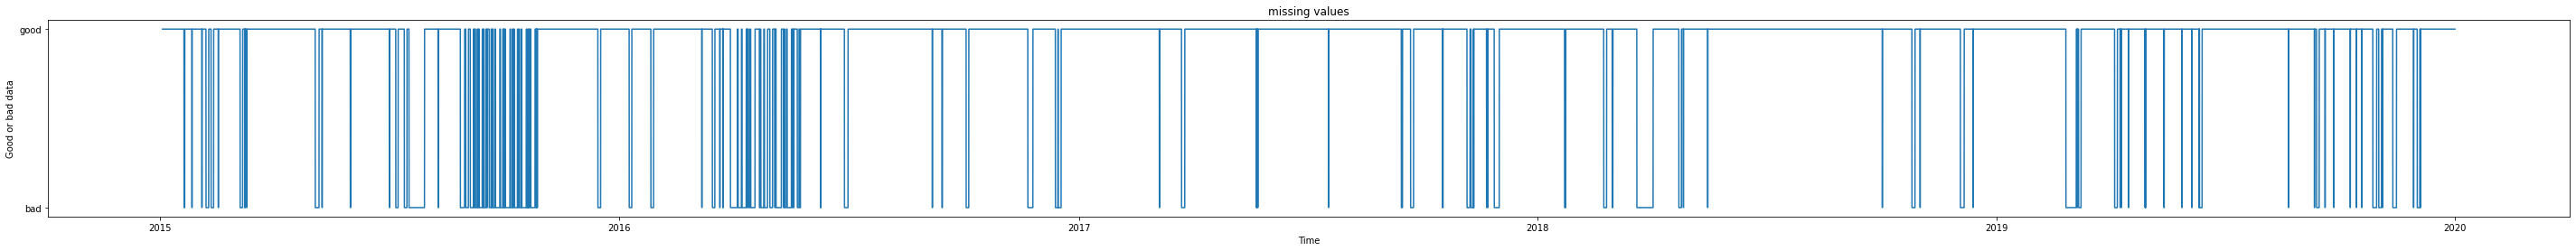

In [12]:
def create_dataset(series_list,lag):

    # Start by joining all data and recomputing with nan-values so timing isn't affected
    df_combined = pd.concat(series_list,axis=1)
    
    df_combined = df_combined.resample('1h').mean() 
    combined_index = df_combined.index
    date_sequences = sliding_window_view(combined_index, lag).squeeze()
    
    output_data = []
    for s in series_list:
        if isinstance(s,pd.Series):
            transformed = s.resample('1h').mean().loc[date_sequences.ravel()].values.reshape(date_sequences.shape)
            output_data.append(transformed)
        else:
            transformed = s.resample('1h').mean().loc[date_sequences.ravel()].values.reshape(date_sequences.shape + (s.shape[1],))
            output_data.append(transformed)
            
    return output_data,date_sequences

# Start and end date for training data because it has to match available radar data
d_start = datetime.datetime(2015,1,1)
d_end = datetime.datetime(2019,12,31,23,59,59)


lag = 48
Y_all = Y.loc[d_start:d_end,drainage_names]#copy()#.interpolate(method='linear',limit = 1)

threshold_dict = {'RVK-GEL':[0,100,200,300,400,600,800,1000],
              'RVK-BOD':[0,25,50,75,100,125,150,200]}
thresholds = np.array(list(threshold_dict.values()))

daily_sum_sorted = Y_all.resample('1d').sum().sum(axis=1).sort_values()[::-1]
top_1000_drainage_days = daily_sum_sorted.index[:1000]


Xt_all = X.loc[d_start:d_end,temperature_name].copy()
Xr_all = X.loc[d_start:d_end,radar_variables].copy()



[Xt_all_seq_dirty,Y_all_seq_dirty,Xr_all_seq_dirty],dates_all_seq_dirty = create_dataset([Xt_all,Y_all,Xr_all],lag)

# Take all but last value away from data where lagged value isn't necessary
if type(Y_all_seq_dirty) == list:
    Y_all_seq_dirty = np.concatenate([i[:,:,np.newaxis] for i in Y_all_seq_dirty],axis=2)

Y_all_seq_dirty = Y_all_seq_dirty[:,-1]

# Drop rows with missing input data or all output data missing
nan_rows = np.isnan(Xt_all_seq_dirty).any(axis=1) | np.isnan(Xr_all_seq_dirty).any(axis=(1,2)) | np.isnan(Y_all_seq_dirty).any(axis=1)

good_rows = ~nan_rows
Xt_all_seq = Xt_all_seq_dirty[good_rows]
Xr_all_seq = Xr_all_seq_dirty[good_rows]

Xt_all_single = Xt_all_seq_dirty[good_rows][:,-1]
Xr_all_single = Xr_all_seq_dirty[good_rows][:,-1]


Y_all_single = Y_all_seq_dirty[good_rows]


dates_all_seq = dates_all_seq_dirty[good_rows]

hour_ohe_seq = OneHotEncoder().fit_transform(pd.DatetimeIndex(dates_all_seq.ravel()).hour.values.reshape(-1,1))
hour_ohe_seq = hour_ohe_seq.toarray().reshape(-1,lag,24)
hour_ohe_single = hour_ohe_seq[:,-1]


# Visualize which parts of the data are good and bad
plt.figure(figsize=(50,4))
plt.plot(dates_all_seq_dirty[:,-1],good_rows*1)
plt.xlabel('Time')
plt.ylabel('Good or bad data')
plt.yticks([0,1],['bad','good'])
plt.title('missing values')
plt.show()

In [15]:
# 

In [13]:
len(dates_all_seq)

38984

# Model evaluation

In [54]:
def CSI(results):
    return results['TP']/(results['TP'] + results['FP'] + results['FN'])


def CSI_per_sensor_per_threshold_aggregate(results):
    results = results.copy().drop(['fold', 'split'], axis=1)
    results = results.groupby(['sensor', 'threshold']).sum()
    for index, row in results.iterrows():
        results.at[index, 'CSI'] = CSI(row)
    results = results.reset_index()
    return results


def CSI_per_sensor_per_threshold(results):
    train = results[results.loc[:, 'split'] == 'train']
    val = results[results.loc[:, 'split'] == 'val']
    results_train = CSI_per_sensor_per_threshold_aggregate(train)
    results_val = CSI_per_sensor_per_threshold_aggregate(val)
    return results_train, results_val


def log_CSI(df_CSI, split):
    CSI_dict = df_CSI.T.to_dict()
    for key in CSI_dict:
        run_dict = CSI_dict[key]
        sensor = run_dict['sensor']
        addition = {f'{split}_CSI_{int(sensor)}': run_dict['CSI']}
        run_dict.update(addition)
        wandb.log(run_dict)


def compute_CLS(iop, thresholds):
    df_all_results = pd.DataFrame(
        columns=['fold', 'split', 'sensor', 'threshold', 'TP', 'FP', 'TN', 'FN'])
    total_results = 0
    # For each fold
    for iop_key in iop:
        model_results = iop[iop_key]

        Y_val = model_results['Y_val'].reshape(-1, 1, 2)
        Y_val_pred = model_results['Y_val_pred'].reshape(-1, 1, 2)
        Y_train = model_results['Y_train'].reshape(-1, 1, 2)
        Y_train_pred = model_results['Y_train_pred'].reshape(-1, 1, 2)

        # For either sensor
        for i, Ts in enumerate(thresholds):
            # for each threshold for that sensor
            for ii, T in enumerate(Ts):
                Y_val_pred_tmp = Y_val_pred[:, :, i]
                Y_val_tmp = Y_val[:, :, i]

                Y_train_pred_tmp = Y_train_pred[:, :, i]
                Y_train_tmp = Y_train[:, :, i]

                Y_val_clf = Y_val_tmp >= T
                Y_val_pred_clf = Y_val_pred_tmp >= T

                Y_train_clf = Y_train_tmp >= T
                Y_train_pred_clf = Y_train_pred_tmp >= T

                # validation
                TP = np.sum(Y_val_clf & Y_val_pred_clf)  # True True
                FP = np.sum(~Y_val_clf & Y_val_pred_clf)  # False True
                TN = np.sum(~Y_val_clf & ~Y_val_pred_clf)  # False False
                FN = np.sum(Y_val_clf & ~Y_val_pred_clf)  # True False
                df_all_results.loc[total_results, :] = [
                    iop_key, 'val', i, T, TP, FP, TN, FN]
                total_results += 1

                # training
                TP = np.sum(Y_train_clf & Y_train_pred_clf)  # True True
                FP = np.sum(~Y_train_clf & Y_train_pred_clf)  # False True
                TN = np.sum(~Y_train_clf & ~Y_train_pred_clf)  # False False
                FN = np.sum(Y_train_clf & ~Y_train_pred_clf)  # True False
                df_all_results.loc[total_results, :] = [
                    iop_key, 'train', i, T, TP, FP, TN, FN]
                total_results += 1
    return df_all_results


def evaluate_MSE(fold_data, evaluation_dict):
    mse = tf.losses.MeanSquaredError(
        tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
    fold = evaluation_dict['fold']
    evaluation_dict['mean_squared_error'] = \
        evaluation_dict[f'mean_squared_error_fold_{fold}'] = \
        mse(fold_data['Y_train'],
            fold_data['Y_train_pred']).numpy()

    evaluation_dict['val_mean_squared_error'] =\
        evaluation_dict[f'val_mean_squared_error_fold_{fold}'] =\
        mse(fold_data['Y_val'],
            fold_data['Y_val_pred']).numpy()


def evaluate_MAE(fold_data, evaluation_dict):
    mae = tf.losses.MeanAbsoluteError(
        tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

    fold = evaluation_dict['fold']
    evaluation_dict['mean_absolute_error'] = \
        evaluation_dict[f'mean_absolute_error_fold_{fold}'] = \
        mae(
        fold_data['Y_train'], fold_data['Y_train_pred']).numpy()
    evaluation_dict['val_mean_absolute_error'] = \
        evaluation_dict[f'val_mean_absolute_error_fold_{fold}'] = \
        mae(
        fold_data['Y_val'], fold_data['Y_val_pred']).numpy()


def standardize(x1, x2):
    return ((x1 - np.min(x1))/(np.max(x1) -
                               np.min(x1)), (x2 - np.min(x1))/(np.max(x1) - np.min(x1)))


def evaluate_model(model_constructor,
                   input_data,
                   output_data,
                   thresholds,
                   fn_crossval='TimeSeriesSplit',
                   folds=5,
                   tensorflow_model=False,
                   multiple_inputs=False,
                   logger=wandb,
                   target_transform=lambda x: x,
                   target_inverse_transform=lambda x: x,
                   apply_argsort=True,
                   **fit_kwargs):

    models = dict()
    evaluation_dict = dict()
    input_output_pred = dict()
    fn_crossval_instance = getattr(sklearn.model_selection, fn_crossval)
    kfold = fn_crossval_instance(folds)

    for i, (train, val) in enumerate(kfold.split(output_data)):

        def apply_log(x): return np.log1p(x)
        def inverse_log(x): return np.expm1(x)
        X_train = []
        X_val = []
        if multiple_inputs:

            for inp in input_data:
                X_train_tmp = inp[train]
                X_val_tmp = inp[val]

                X_train_tmp, X_val_tmp = standardize(X_train_tmp, X_val_tmp)
                X_train.append(X_train_tmp)
                X_val.append(X_val_tmp)

        else:
            X_train = input_data[train]
            X_val = input_data[val]
            X_train, X_val = standardize(X_train, X_val)

        Y_train = target_transform(output_data[train])
        Y_val = target_transform(output_data[val])

        model = model_constructor()

        print(Y_train.shape)
        if (tensorflow_model):
            model.fit(X_train,
                      Y_train,
                      validation_data=(X_val, Y_val),
                      **fit_kwargs)
        else:
            model.fit(X_train, Y_train, **fit_kwargs)
        Y_train_pred = model.predict(X_train)
        Y_val_pred = model.predict(X_val)

        # inverse-log (Exponential) transform for evaluation
        Y_train = target_inverse_transform(Y_train)
        Y_val = target_inverse_transform(Y_val)
        Y_train_pred = target_inverse_transform(Y_train_pred)
        Y_val_pred = target_inverse_transform(Y_val_pred)

        # Insert fold data and predictions for better packaging
        fold_data = {}
        fold_data['X_train'] = X_train
        fold_data['X_val'] = X_val
        # in order to proceede with normal shape
        
        fold_data['Y_train'] = Y_train
        fold_data['Y_val'] = Y_val
        fold_data['Y_train_pred'] = Y_train_pred
        fold_data['Y_val_pred'] = Y_val_pred
    
        # Evaluation functions
        wandb.config['fold'] = i
        fold_evaluation_stats = {}
        fold_evaluation_stats['fold'] = i
        evaluate_MSE(fold_data,fold_evaluation_stats)
        evaluate_MAE(fold_data,fold_evaluation_stats)

        logger.log(fold_evaluation_stats)
        
        models[i] = model
        evaluation_dict[i] = fold_evaluation_stats
        input_output_pred[i] = fold_data
    
    # log CSI afterwards across all folds (on validation performance only)
    df_results = compute_CLS(input_output_pred,thresholds)
    df_CSI_train,df_CSI_val = CSI_per_sensor_per_threshold(df_results)
    log_CSI(df_CSI_train,'train')
    log_CSI(df_CSI_val,'val')
    
    return evaluation_dict, models, input_output_pred


## Common settings

In [8]:
cross_validation = {
    'fn_kfold':'TimeSeriesSplit',
    'folds':5,
    'n_targets':2,
    }
loss = 'Mean Squared Error'
project = 'thesis_experiment_radar_input_CSI tests'


## Linear models

### Only radar

In [9]:
config_linear = {
    'name': 'Ridge regression',
    'loss': loss,
    'cross_validation':cross_validation,
    'lag' : 1,
    'alpha' : 5,
    'delay' : 1,
}


# from Models import LinearModel
wandb.init(project=project, config=config_linear)

def linear_model(alpha=0):
    return lambda : Ridge(alpha) 

n,l,p = Xr_all_seq.shape

if 'delay' in wandb.config and wandb.config['delay'] > 0:
    Xr_all_seq_delay = Xr_all_seq[:-wandb.config['delay']]
    Y_all_single_delay = Y_all_single[wandb.config['delay']:]
    n,l,p = Xr_all_seq_delay.shape
else:
    Xr_all_seq_delay = Xr_all_seq
    Y_all_single_delay = Y_all_single
X1 = Xr_all_seq_delay[:,-wandb.config['lag'],:].reshape(n,-1)
(history_linear,models_linear,iop_linear) =\
        evaluate_model(model_constructor=linear_model(wandb.config['alpha']),
                       input_data=X1, # Flatten all non-sample dims
                       output_data = Y_all_single_delay,
                       thresholds = thresholds,
                       fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                       folds=wandb.config['cross_validation']['folds'],
                       tensorflow_model=False,
                       multiple_inputs=False,
                       logger = wandb,
                       
                       )

### Radar and temperature

In [10]:
config_linear_w_temp = {
    'name': 'Ridge regression w temp',
    'loss': loss,
    'cross_validation':cross_validation,
    'lag' : 2,
    'alpha' : 20,
    'delay' : 0,
}

# from Models import LinearModel
wandb.init(project=project, config=config_linear_w_temp)

def linear_model(alpha=0):
    return lambda : Ridge(alpha) 

n,l,p = Xr_all_seq.shape

if 'delay' in wandb.config and wandb.config['delay'] > 0:
    Xr_all_seq_delay = Xr_all_seq[:-wandb.config['delay']]
    Xt_all_seq_delay = Xt_all_seq[:-wandb.config['delay']]
    Y_all_single_delay = Y_all_single[wandb.config['delay']:]
    n,l,p = Xr_all_seq_delay.shape
else:
    Xr_all_seq_delay = Xr_all_seq
    Xt_all_seq_delay = Xt_all_seq
    Y_all_single_delay = Y_all_single


X1 = Xr_all_seq_delay[:,-wandb.config['lag']:,:].reshape(n,-1)
X2 = Xt_all_seq_delay
Y1 = Y_all_single_delay

(history_linear_w_temp,models_linear_w_temp,iop_linear_w_temp) =\
        evaluate_model(model_constructor=linear_model(wandb.config['alpha']),
                       input_data=np.c_[X1,X2],
                       output_data = Y1,
                       thresholds = thresholds,
                       fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                       folds=wandb.config['cross_validation']['folds'],
                       tensorflow_model=False,
                       multiple_inputs=False,
                       logger = wandb,
                       )

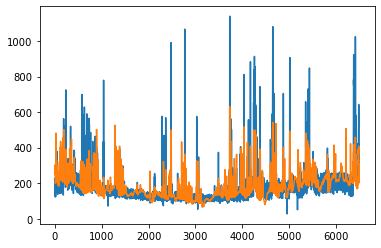

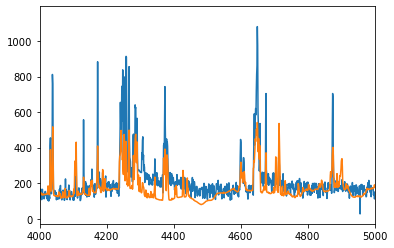

In [12]:
plt.plot(iop_linear_w_temp[4]['Y_val'][:,0])
plt.plot(iop_linear_w_temp[4]['Y_val_pred'][:,0])
plt.show()

plt.plot(iop_linear_w_temp[4]['Y_val'][:,0])
plt.plot(iop_linear_w_temp[4]['Y_val_pred'][:,0])
plt.xlim(4000,5000)
plt.show()

In [13]:
config_linear_w_temp_and_ohe = {
    'name': 'Linear model w temp and pattern',
    'loss': loss,
    'cross_validation':cross_validation,
    'lag' : 2,
    'alpha' : 20,
    'delay' : 0,
}


# from Models import LinearModel
wandb.init(project=project, config=config_linear_w_temp_and_ohe)

def linear_model(alpha=0):
    return lambda : Ridge(alpha) 

n,l,p = Xr_all_seq.shape

if 'delay' in wandb.config and wandb.config['delay'] > 0:
    Xr_all_seq_delay = Xr_all_seq[:-wandb.config['delay']]
    Xt_all_seq_delay = Xt_all_seq[:-wandb.config['delay']]
    hour_ohe_seq_delay = hour_ohe_seq[:-wandb.config['delay']]
    Y_all_single_delay = Y_all_single[wandb.config['delay']:]
    n,l,p = Xr_all_seq_delay.shape
else:
    Xr_all_seq_delay = Xr_all_seq
    Xt_all_seq_delay = Xt_all_seq
    hour_ohe_seq_delay = hour_ohe_seq
    Y_all_single_delay = Y_all_single

n1,l1,p1 = Xr_all_seq_delay.shape
n2,l2,p2 = hour_ohe_seq_delay.shape

X1 = Xr_all_seq_delay[:,-wandb.config['lag']:,:].reshape(n1,-1)
X2 = Xt_all_seq_delay
X3 = hour_ohe_seq_delay.reshape(n2,-1)
Y1 = Y_all_single_delay

(history_linear_w_temp_and_ohe,models_linear_w_temp_and_ohe,iop_linear_w_temp_and_ohe) =\
        evaluate_model(model_constructor=linear_model(wandb.config['alpha']),
                       input_data=np.c_[X1,X2,X3],
                       output_data = Y1,
                       thresholds = thresholds,
                       fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                       folds=wandb.config['cross_validation']['folds'],
                       tensorflow_model=False,
                       multiple_inputs=False)



## Neural network models


### Common components

In [14]:
district_heating = {
    'n_rolling_temperature':24,
    'dense_1': 5,
    'dense_2': 2,
    'activation_1': 'relu',
    'activation_2': 'relu',
     }

pattern = {
    'pattern_length': 24,
    'pattern_constraint':'nonneg',
}
   
optimizer_params = {
    'name': 'Adam',
    'learning_rate': 0.001,
    'decay': 0.0,
    'beta_1': 0.9,
    'beta_2': 0.999,
    'epsilon': 1e-07,
    'amsgrad': False
    }

early_stopper_params = {
    'monitor': 'val_loss',
    'min_delta': 0,
    'patience': 20,
    'verbose': 0,
    'mode': 'min',
    'baseline': None,
    'restore_best_weights': True,
    }

def lr_schedule(epoch, lr):
    learning_rates = np.logspace(wandb.config['learning_rate']['inital_log'],
                                 wandb.config['learning_rate']['final_log'],
                                 wandb.config['learning_rate']['intervals'])
    epochs = wandb.config['epochs']
    n_lr = wandb.config['learning_rate']['intervals']

    return learning_rates[int(epoch/epochs * n_lr)]

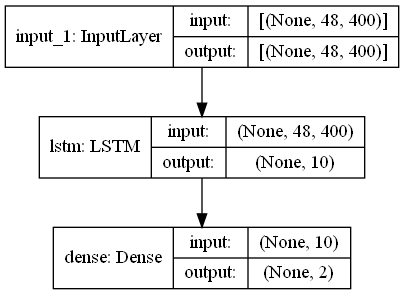

In [15]:
config_recurrent_simple = {
    'name': 'Simple recurrent model',
    'random_seed': 99,
    'loss': loss,
    'cross_validation': cross_validation,
    'optimizer': optimizer_params,
    'early_stopper': early_stopper_params,
    'lag' : 24,
    'delay' : 0,
    # model

    'rainfall_runoff': {
        'lag': 48,
        'l2_regularization' : 20,
        'lstm': 10,
        'dense_1': 2,
        'activation_1': 'linear',
    },
    # Training
    'batch_size': 24*3,
    'epochs': 60,
    'learning_rate': {
        'inital_log': -1,
        'final_log': -3.5,
        'intervals': 100,
    },

}

wandb.init(project=project, config=config_recurrent_simple)


# logging_callback = wandb.keras.WandbCallback(log_evaluation=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
early_stopper = tf.keras.callbacks.EarlyStopping(
    **wandb.config['early_stopper'])

# wandb.init(project=project, config=config)


def simple_recurrent_model():
    tf.random.set_seed(wandb.config['random_seed'])
    # District heating - only input: 24 hour rolling average of temperature

    # Rainfall runoff only input: rain-gauge
    model = Sequential([
        Input((wandb.config['rainfall_runoff']['lag'],400)),
        # Dense(1,activation = 'linear',
        #       kernel_regularizer = tf.keras.regularizers.l2(
        #           wandb.config['rainfall_runoff']['l2_regularization'])),
        LSTM(wandb.config['rainfall_runoff']['lstm']),
        Dense(wandb.config['rainfall_runoff']['dense_1'],
              wandb.config['rainfall_runoff']['activation_1']),
    ], 'rain_gauge')

    tf.keras.optimizers.get('Adam')

    optimizer = tf.keras.optimizers.get(
        {"class_name": wandb.config['optimizer']['name'],
         "config": wandb.config['optimizer']})

    model.compile(optimizer=optimizer,
                  loss=tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE, tfp.stats.correlation]
                  )

    return model


tf.keras.utils.plot_model(simple_recurrent_model(),
                          show_layer_names=True,
                          show_shapes=True,
                          expand_nested=True)


In [16]:
Xr_all_seq_delay[:,-wandb.config['lag']:,:].shape

(38984, 24, 400)

In [17]:
if 'delay' in wandb.config and wandb.config['delay'] > 0:
    Xr_all_seq_delay = Xr_all_seq[:-wandb.config['delay']]
    Xt_all_seq_delay = Xt_all_seq[:-wandb.config['delay']]
    hour_ohe_seq_delay = hour_ohe_seq[:-wandb.config['delay']]
    Y_all_single_delay = Y_all_single[wandb.config['delay']:]
    n,l,p = Xr_all_seq_delay.shape
else:
    Xr_all_seq_delay = Xr_all_seq
    Xt_all_seq_delay = Xt_all_seq
    hour_ohe_seq_delay = hour_ohe_seq
    Y_all_single_delay = Y_all_single

n1,l1,p1 = Xr_all_seq_delay.shape
n2,l2,p2 = hour_ohe_seq_delay.shape

X1 = Xr_all_seq_delay[:,-wandb.config['lag']:,:]
X2 = Xt_all_seq_delay
X3 = hour_ohe_seq_delay.reshape(n2,-1)
Y1 = Y_all_single_delay

# with tf.device('/gpu:0'):
with tf.device('/cpu:0'):
    (history_recurr_simple,models_recurr_simple,iop_recurr_simple) =\
         evaluate_model(model_constructor=simple_recurrent_model,
                       input_data=X1,
                       output_data = Y1,
                       thresholds = thresholds,
                        fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                        folds=wandb.config['cross_validation']['folds'],
                        tensorflow_model=True,
                        multiple_inputs=False,
                        # Kwargs
                        batch_size=wandb.config['batch_size'],
                        epochs=wandb.config['epochs'],
                        shuffle=True,
                        callbacks=[
                            lr_scheduler,
                            early_stopper,
                            # logging_callback
                            ],
                          verbose=1
                          )

Epoch 1/60
91/91 [==============================] - 9s 38ms/step - loss: 25094.8730 - mean_absolute_error: 104.0036 - mean_squared_error: 25094.8730 - correlation: 0.1270 - val_loss: 12798.4883 - val_mean_absolute_error: 59.9071 - val_mean_squared_error: 12798.4883 - val_correlation: 0.0956
Epoch 2/60
91/91 [==============================] - 2s 23ms/step - loss: 14359.3379 - mean_absolute_error: 63.2058 - mean_squared_error: 14359.3379 - correlation: 0.2120 - val_loss: 8661.4902 - val_mean_absolute_error: 46.7871 - val_mean_squared_error: 8661.4902 - val_correlation: 0.1156
Epoch 3/60
91/91 [==============================] - 2s 22ms/step - loss: 10878.8223 - mean_absolute_error: 52.7332 - mean_squared_error: 10878.8223 - correlation: 0.2037 - val_loss: 7780.1826 - val_mean_absolute_error: 46.5272 - val_mean_squared_error: 7780.1826 - val_correlation: 0.1063
Epoch 4/60
91/91 [==============================] - 2s 20ms/step - loss: 9873.1494 - mean_absolute_error: 50.5520 - mean_squared_e

### Recurrent with temperature

### Simple conceptual model

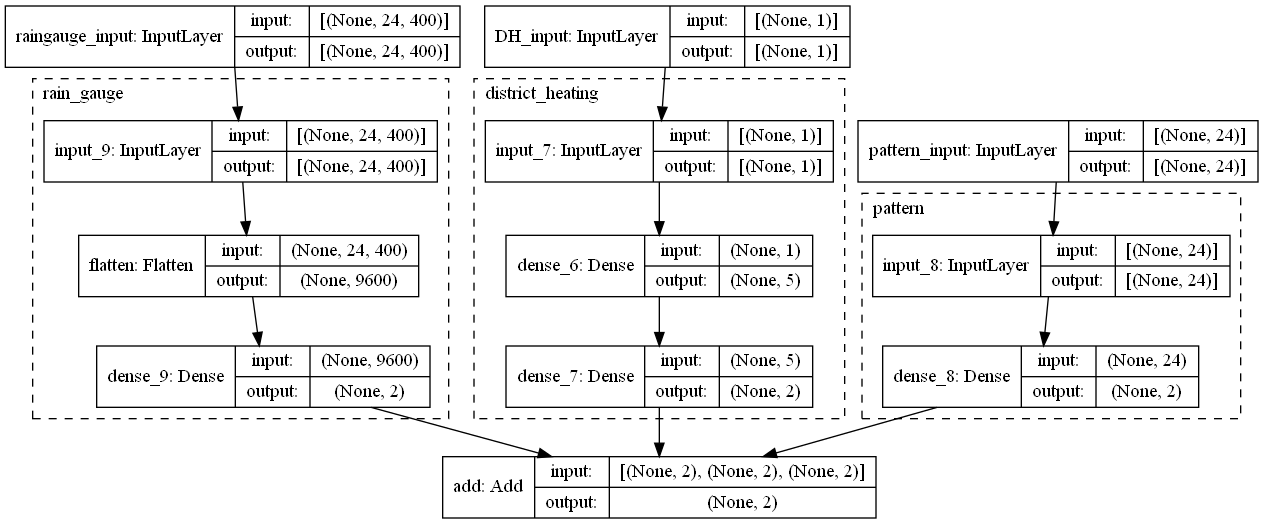

In [18]:
config_conceptual_simple = {
    'name': 'Simple conceptual model',
    'random_seed': 99,
    'loss': loss,
    'cross_validation': cross_validation,
    'optimizer': optimizer_params,
    'early_stopper': early_stopper_params,
    # model
    'district_heating': district_heating,
    'pattern': pattern,
    'delay' : 0,
    'rainfall_runoff': {
        'lag': 24,
        'l2_regularization' : 20,
        'dense_1': 2,
        'activation_1': 'linear',
    },
    # Training
    'batch_size': 24,
    'epochs': 120,
    'learning_rate': {
        'inital_log': -0.5,
        'final_log': -4,
        'intervals': 100,
    },
}

wandb.init(project=project, config=config_conceptual_simple)


def lr_schedule(epoch, lr):
    learning_rates = np.logspace(wandb.config['learning_rate']['inital_log'],
                                 wandb.config['learning_rate']['final_log'],
                                 wandb.config['learning_rate']['intervals'])
    epochs = wandb.config['epochs']
    n_lr = wandb.config['learning_rate']['intervals']

    return learning_rates[int(epoch/epochs * n_lr)]


# logging_callback = wandb.keras.WandbCallback(log_evaluation=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
early_stopper = tf.keras.callbacks.EarlyStopping(
    **wandb.config['early_stopper'])


# wandb.init(project=project, config=config)


def conceptual_model_simple():
    # wandb.init(project=project, config=config_conceptual_simple)
    tf.random.set_seed(wandb.config['random_seed'])
    # District heating - only input: 24 hour rolling average of temperature
    District_heating = Sequential([
        Input((1,)),
        Dense(wandb.config['district_heating']['dense_1'],
              wandb.config['district_heating']['activation_1']),
        Dense(wandb.config['district_heating']['dense_2'],
              wandb.config['district_heating']['activation_2']),
    ], name='district_heating')

    # Daily pattern (One-hot-encoded)
    Daily_pattern = Sequential([
        Input(wandb.config['pattern']['pattern_length']),
        Dense(2,
              activation='linear',
              use_bias=False,
              kernel_constraint=tf.keras.constraints.get(
                  wandb.config['pattern']['pattern_constraint']))
    ], name='pattern')

    # Rainfall runoff only input: rain-gauge
    Rainfall_runoff = Sequential([
        Input((wandb.config['rainfall_runoff']['lag'],400)),
        Flatten(),
        Dense(wandb.config['rainfall_runoff']['dense_1'],
              wandb.config['rainfall_runoff']['activation_1']),
    ], 'rain_gauge')

    District_heating_input = Input((1,), name='DH_input')
    Daily_pattern_input = Input(
        (wandb.config['pattern']['pattern_length'],), name='pattern_input')
    Rainfall_runoff_input = Input(
        (wandb.config['rainfall_runoff']['lag'],400), name='raingauge_input')

    District_heating_output = District_heating(District_heating_input)
    Daily_pattern_output = Daily_pattern(Daily_pattern_input)
    Rainfall_runoff_output = Rainfall_runoff(Rainfall_runoff_input)

    combined_output = tf.keras.layers.add(
        [Rainfall_runoff_output, District_heating_output, Daily_pattern_output])

    model = tf.keras.Model([District_heating_input,
                            Daily_pattern_input,
                            Rainfall_runoff_input],
                           combined_output)

    tf.keras.optimizers.get('Adam')

    optimizer = tf.keras.optimizers.get(
        {"class_name": wandb.config['optimizer']['name'],
         "config": wandb.config['optimizer']})

    model.compile(optimizer=optimizer,
                  loss=tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE, tfp.stats.correlation]
                  )

    return model


tf.keras.utils.plot_model(conceptual_model_simple(),
                          show_layer_names=True,
                          show_shapes=True,
                          expand_nested=True)



In [38]:
threshold_dict = {'RVK-GEL': [0, 100, 200, 300, 400, 600, 800, 1000],
                  'RVK-BOD': [0, 25, 50, 75, 100, 125, 150, 200]}
thresholds = np.array(list(threshold_dict.values()))

In [42]:
if 'delay' in wandb.config and wandb.config['delay'] > 0:
    Xr_all_seq_delay = Xr_all_seq[:-wandb.config['delay']]
    Xt_all_single_delay = Xt_all_single[:-wandb.config['delay']]
    hour_ohe_single_delay = hour_ohe_single[:-wandb.config['delay']]
    Y_all_single_delay = Y_all_single[wandb.config['delay']:]
    n,l,p = Xr_all_seq_delay.shape
else:
    Xr_all_seq_delay = Xr_all_seq
    Xt_all_single_delay = Xt_all_single
    hour_ohe_single_delay = hour_ohe_single
    Y_all_single_delay = Y_all_single

n1,l1,p1 = Xr_all_seq_delay.shape
n2,p2 = hour_ohe_single_delay.shape

X1 = Xr_all_seq_delay[:,-wandb.config['rainfall_runoff']['lag']:,:]
X2 = Xt_all_single_delay.reshape(-1,1)
X3 = hour_ohe_single_delay.reshape(n2,-1)
Y1 = Y_all_single_delay


# with tf.device('/gpu:0'):
with tf.device('/cpu:0'):
    (history_con_simple, models_con_simple, iop_con_simple) =\
         evaluate_model(model_constructor=conceptual_model_simple,
                        input_data=[
                              X2,
                              X3,
                              X1],
                        output_data=Y_all_single,
                       thresholds = thresholds,
                        fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                        folds=wandb.config['cross_validation']['folds'],
                        tensorflow_model=True,
                        multiple_inputs=True,
                        # Kwargs
                        batch_size=wandb.config['batch_size'],
                        epochs=wandb.config['epochs'],
                        shuffle=True,
                        callbacks=[
                            lr_scheduler,
                            early_stopper,
                            # logging_callback
                        ],
                        verbose = 1)


### Conceptual model with recurrent rainfall runoff

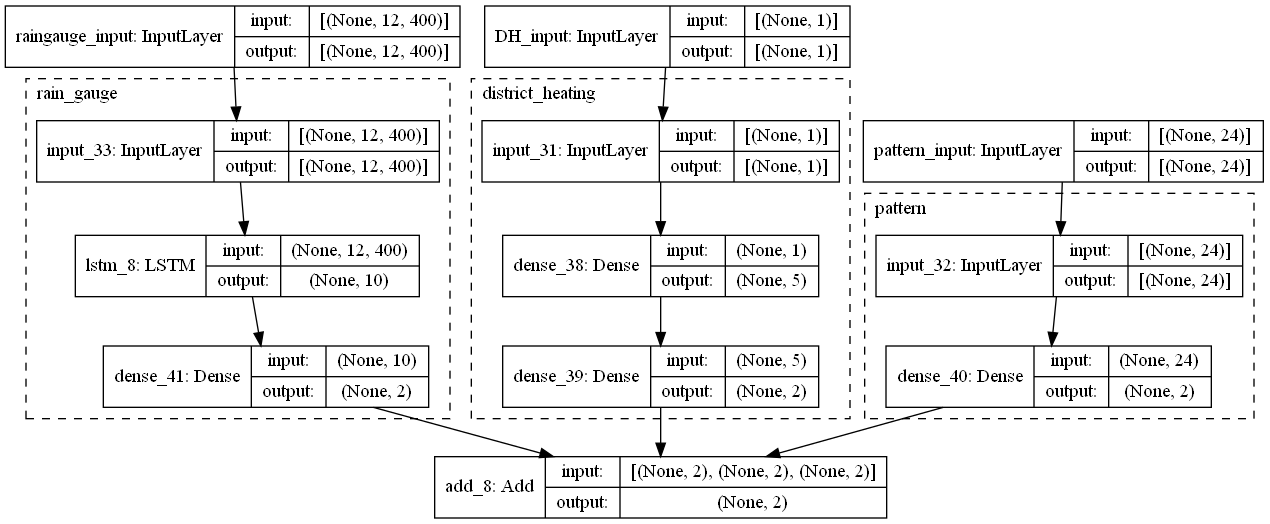

In [22]:
lag = 12
config_conceptual_recurrent = {
    'name': 'Conceptual model with recurrent rainfall-runoff',
    'random_seed': 99,
    'loss': loss,
    'cross_validation': cross_validation,
    'optimizer': optimizer_params,
    'early_stopper': early_stopper_params,
    # model
    'district_heating': district_heating,
    'pattern': pattern,
    'lag' : lag,
    'delay' : 0,

    'rainfall_runoff': {
        'lag': lag,
        'l2_regularization' : 5,
        'lstm': 10,
        'dense_1': 2,
        'activation_1': 'relu'
    },
    # Training
    'batch_size': 24,
    'epochs': 150,
    'learning_rate': {
        'inital_log': 0,
        'final_log': -3.5,
        'intervals': 100,
    },

}
wandb.init(project=project, config=config_conceptual_recurrent)


def lr_schedule(epoch, lr):
    learning_rates = np.logspace(wandb.config['learning_rate']['inital_log'],
                                 wandb.config['learning_rate']['final_log'],
                                 wandb.config['learning_rate']['intervals'])
    epochs = wandb.config['epochs']
    n_lr = wandb.config['learning_rate']['intervals']

    return learning_rates[int(epoch/epochs * n_lr)]


logging_callback = wandb.keras.WandbCallback(log_evaluation=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)
early_stopper = tf.keras.callbacks.EarlyStopping(
    **wandb.config['early_stopper'])

def conceptual_model_recurrent():

    tf.random.set_seed(99)

    # District heating - only input: 24 hour rolling average of temperature
    District_heating = Sequential([
        Input((1,)),
        Dense(wandb.config['district_heating']['dense_1'],
              'linear'),
        Dense(wandb.config['district_heating']['dense_2'],
              'linear'),
    ], name='district_heating')

    # Daily pattern (One-hot-encoded)
    Daily_pattern = Sequential([
        Input(wandb.config['pattern']['pattern_length']),
        Dense(2,
              activation='linear',
              use_bias=False,
              kernel_constraint=tf.keras.constraints.get(
                  wandb.config['pattern']['pattern_constraint']
              ))], name='pattern')

    # Rainfall runoff only input: rain-gauge
    Rainfall_runoff = Sequential([
        Input((wandb.config['rainfall_runoff']['lag'],400)),
        LSTM(wandb.config['rainfall_runoff']['lstm']),
        Dense(wandb.config['rainfall_runoff']['dense_1'],
              wandb.config['rainfall_runoff']['activation_1']),
    ], 'rain_gauge')

    District_heating_input = Input((1,), name='DH_input')
    Daily_pattern_input = Input(
        (wandb.config['pattern']['pattern_length'],), name='pattern_input')
    Rainfall_runoff_input = Input(
        (wandb.config['rainfall_runoff']['lag'], 400), name='raingauge_input')

    District_heating_output = District_heating(District_heating_input)
    Daily_pattern_output = Daily_pattern(Daily_pattern_input)
    Rainfall_runoff_output = Rainfall_runoff(Rainfall_runoff_input)

    combined_output = tf.keras.layers.add(
        [Rainfall_runoff_output, District_heating_output, Daily_pattern_output])

    model = tf.keras.Model([District_heating_input,
                            Daily_pattern_input,
                            Rainfall_runoff_input],
                           combined_output)

    tf.keras.optimizers.get('Adam')

    optimizer = tf.keras.optimizers.get(
        {"class_name": wandb.config['optimizer']['name'],
         "config": wandb.config['optimizer']})

    model.compile(optimizer=optimizer,
                  loss=tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE, tfp.stats.correlation]
                  )

    return model

tf.keras.utils.plot_model(conceptual_model_recurrent(),
                          show_layer_names=True,
                          show_shapes=True,
                          expand_nested=True)


In [23]:
if 'delay' in wandb.config and wandb.config['delay'] > 0:
    Xr_all_seq_delay = Xr_all_seq[:-wandb.config['delay']]
    Xt_all_single_delay = Xt_all_single[:-wandb.config['delay']]
    hour_ohe_single_delay = hour_ohe_single[:-wandb.config['delay']]
    Y_all_single_delay = Y_all_single[wandb.config['delay']:]
    n,l,p = Xr_all_seq_delay.shape
else:
    Xr_all_seq_delay = Xr_all_seq
    Xt_all_single_delay = Xt_all_single
    hour_ohe_single_delay = hour_ohe_single
    Y_all_single_delay = Y_all_single

n1,l1,p1 = Xr_all_seq_delay.shape
n2,p2 = hour_ohe_single_delay.shape

X1 = Xr_all_seq_delay[:,-wandb.config['rainfall_runoff']['lag']:,:]
X2 = Xt_all_single_delay.reshape(-1,1)
X3 = hour_ohe_single_delay.reshape(n2,-1)
Y1 = Y_all_single_delay



# with tf.device('/gpu:0'):
with tf.device('/cpu:0'):
    (history_dict_conceptual_recurrent,
     models_conceptual_recurrent, iop_conceptual_recurrent) =\
          evaluate_model(model_constructor=conceptual_model_recurrent,
                        input_data=[
                              X2,
                              X3,
                              X1],
                        output_data=Y_all_single,
                       thresholds = thresholds,
                        fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                        folds=wandb.config['cross_validation']['folds'],
                        tensorflow_model=True,
                        multiple_inputs=True,
                        # Kwargs
                        batch_size=wandb.config['batch_size'],
                        epochs=wandb.config['epochs'],
                        shuffle=True,
                        callbacks=[
                            lr_scheduler,
                            early_stopper,
                            # logging_callback
                        ],
                        verbose = 1)

Epoch 1/150

Epoch 00001: LearningRateScheduler setting learning rate to 1.0.
271/271 [==============================] - 3s 5ms/step - loss: 9280.4961 - mean_absolute_error: 50.3295 - mean_squared_error: 9280.4961 - correlation: 0.2886 - val_loss: 6974.8008 - val_mean_absolute_error: 39.9415 - val_mean_squared_error: 6974.8008 - val_correlation: 0.1818
Epoch 2/150

Epoch 00002: LearningRateScheduler setting learning rate to 1.0.
271/271 [==============================] - 1s 4ms/step - loss: 8823.6055 - mean_absolute_error: 48.0184 - mean_squared_error: 8823.6055 - correlation: 0.3342 - val_loss: 6814.9561 - val_mean_absolute_error: 37.0617 - val_mean_squared_error: 6814.9561 - val_correlation: 0.2609
Epoch 3/150

Epoch 00003: LearningRateScheduler setting learning rate to 0.9218207178777467.
271/271 [==============================] - 1s 4ms/step - loss: 8856.3037 - mean_absolute_error: 48.2007 - mean_squared_error: 8856.3037 - correlation: 0.3341 - val_loss: 6825.3076 - val_mean_absolu

In [ ]:
# import scipy
# import datetime
# import re
# import os


# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np
# import tensorflow as tf
# import tensorflow_probability as tfp
# import seaborn as sns

# from glob import glob
# from missingno import matrix
# from numpy.lib.stride_tricks import sliding_window_view
# from tensorflow.keras.layers import *
# from tensorflow.keras import Sequential
# from tensorflow.data import Dataset
# from sklearn.metrics import mean_absolute_error,mean_squared_error



# Other

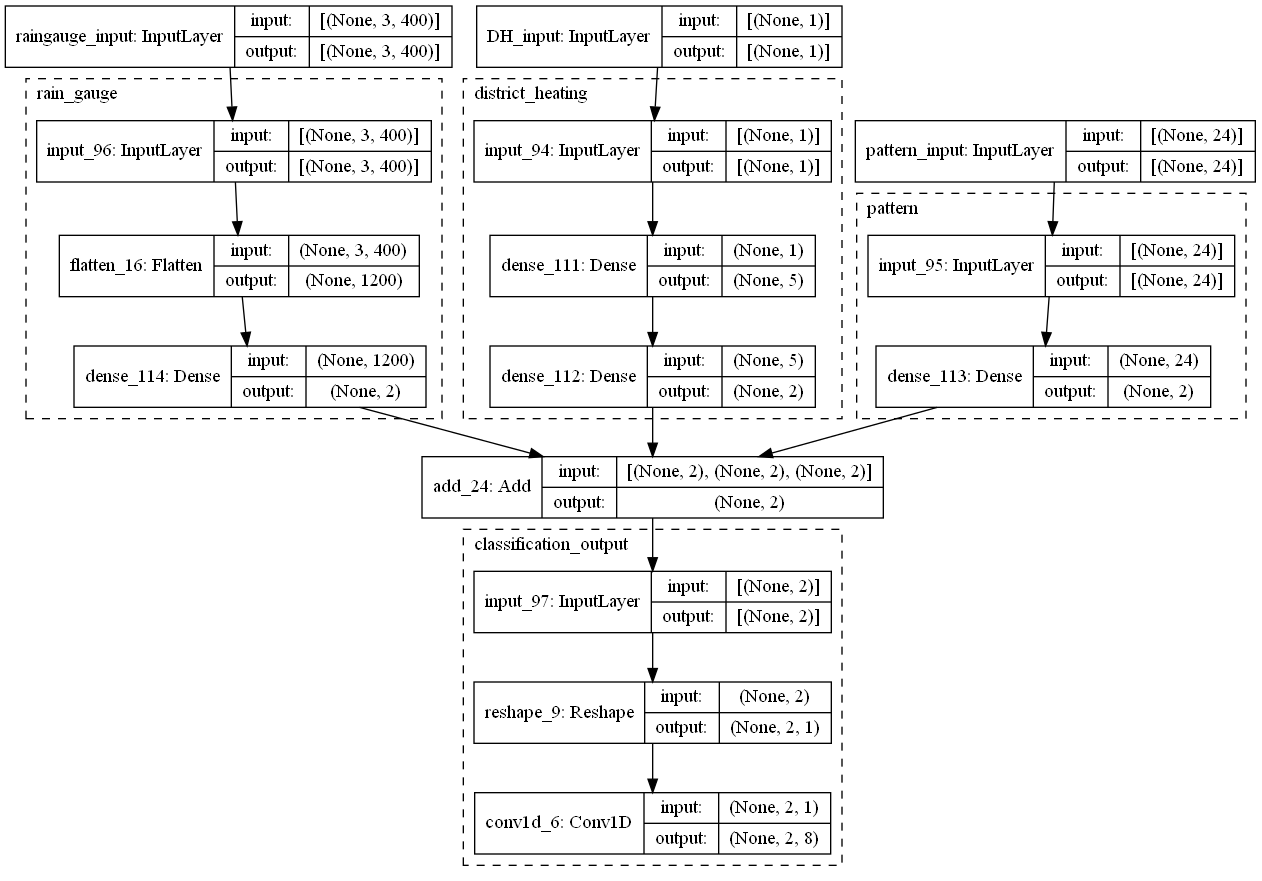

In [60]:
config_conceptual_simple = {
    'name': 'Simple conceptual model',
    'random_seed': 99,
    'loss': loss,
    'cross_validation': cross_validation,
    'optimizer': optimizer_params,
    'early_stopper': early_stopper_params,
    # model
    'district_heating': district_heating,
    'pattern': pattern,
    'delay' : 0,
    'rainfall_runoff': {
        'lag': 3,
        'l2_regularization' : 20,
        'dense_1': 2,
        'activation_1': 'linear',
    },
    # Training
    'batch_size': 24,
    'epochs': 120,
    'learning_rate': {
        'inital_log': -0.5,
        'final_log': -4,
        'intervals': 100,
    },
}

wandb.init(project=project, config=config_conceptual_simple)


def lr_schedule(epoch, lr):
    learning_rates = np.logspace(wandb.config['learning_rate']['inital_log'],
                                 wandb.config['learning_rate']['final_log'],
                                 wandb.config['learning_rate']['intervals'])
    epochs = wandb.config['epochs']
    n_lr = wandb.config['learning_rate']['intervals']

    return learning_rates[int(epoch/epochs * n_lr)]


# logging_callback = wandb.keras.WandbCallback(log_evaluation=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
early_stopper = tf.keras.callbacks.EarlyStopping(
    **wandb.config['early_stopper'])


# wandb.init(project=project, config=config)


def conceptual_classification_model_simple():
    # wandb.init(project=project, config=config_conceptual_simple)
    tf.random.set_seed(wandb.config['random_seed'])
    # District heating - only input: 24 hour rolling average of temperature
    District_heating = Sequential([
        Input((1,)),
        Dense(wandb.config['district_heating']['dense_1'],
              wandb.config['district_heating']['activation_1']),
        Dense(wandb.config['district_heating']['dense_2'],
              wandb.config['district_heating']['activation_2']),
    ], name='district_heating')

    # Daily pattern (One-hot-encoded)
    Daily_pattern = Sequential([
        Input(wandb.config['pattern']['pattern_length']),
        Dense(2,
              activation='linear',
              use_bias=False,
              kernel_constraint=tf.keras.constraints.get(
                  wandb.config['pattern']['pattern_constraint']))
    ], name='pattern')


    # Rainfall runoff only input: rain-gauge
    Rainfall_runoff = Sequential([
        Input((wandb.config['rainfall_runoff']['lag'],400)),
        Flatten(),
        Dense(wandb.config['rainfall_runoff']['dense_1'],
              wandb.config['rainfall_runoff']['activation_1']),
    ], 'rain_gauge')

    # sigmoid output
    classification_layer = Sequential([
        Input((2)),
        Reshape((2, 1)),
        Conv1D(8, 1, activation='sigmoid'),
        # Activation('sigmoid')
    ], 'classification_output')
    
    District_heating_input = Input((1,), name='DH_input')
    Daily_pattern_input = Input(
        (wandb.config['pattern']['pattern_length'],), name='pattern_input')
    Rainfall_runoff_input = Input(
        (wandb.config['rainfall_runoff']['lag'],400), name='raingauge_input')

    District_heating_output = District_heating(District_heating_input)
    Daily_pattern_output = Daily_pattern(Daily_pattern_input)
    Rainfall_runoff_output = Rainfall_runoff(Rainfall_runoff_input)

    combined_output = tf.keras.layers.add(
        [Rainfall_runoff_output, District_heating_output, Daily_pattern_output])


    classification_output = classification_layer(combined_output)

    model = tf.keras.Model([District_heating_input,
                            Daily_pattern_input,
                            Rainfall_runoff_input],
                           classification_output)

    tf.keras.optimizers.get('Adam')

    optimizer = tf.keras.optimizers.get(
        {"class_name": wandb.config['optimizer']['name'],
         "config": wandb.config['optimizer']})

    model.compile(optimizer=optimizer,
                  loss=tf.losses.binary_crossentropy,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE, tfp.stats.correlation]
                  )

    return model


tf.keras.utils.plot_model(conceptual_classification_model_simple(),
                          show_layer_names=True,
                          show_shapes=True,
                          expand_nested=True)



In [61]:
if 'delay' in wandb.config and wandb.config['delay'] > 0:
    Xr_all_seq_delay = Xr_all_seq[:-wandb.config['delay']]
    Xt_all_single_delay = Xt_all_single[:-wandb.config['delay']]
    hour_ohe_single_delay = hour_ohe_single[:-wandb.config['delay']]
    Y_all_single_delay = Y_all_single[wandb.config['delay']:]
    n,l,p = Xr_all_seq_delay.shape
else:
    Xr_all_seq_delay = Xr_all_seq
    Xt_all_single_delay = Xt_all_single
    hour_ohe_single_delay = hour_ohe_single
    Y_all_single_delay = Y_all_single

n1,l1,p1 = Xr_all_seq_delay.shape
n2,p2 = hour_ohe_single_delay.shape

X1 = Xr_all_seq_delay[:,-wandb.config['rainfall_runoff']['lag']:,:]
X2 = Xt_all_single_delay.reshape(-1,1)
X3 = hour_ohe_single_delay.reshape(n2,-1)
Y1 = Y_all_single_delay


Y1_tmp_cls = np.zeros(Y1.shape + (8,))
for i, (t1, t2) in enumerate(thresholds.T):
    Y1_tmp_cls[:, 0, i] = (Y1[:, 0] > t1)*1
    Y1_tmp_cls[:, 1, i] = (Y1[:, 1] > t2)*1


In [62]:
Y1_tmp_cls.shape

(38984, 2, 8)

In [63]:
# with tf.device('/gpu:0'):
with tf.device('/cpu:0'):
    (history_con_simple, models_con_simple, iop_con_simple) =\
         evaluate_model(model_constructor=conceptual_classification_model_simple,
                        input_data=[
                              X2,
                              X3,
                              X1],
                        output_data=Y1_tmp_cls,
                       thresholds = thresholds,
                        fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                        folds=wandb.config['cross_validation']['folds'],
                        tensorflow_model=True,
                        multiple_inputs=True,
                        # Kwargs
                        batch_size=wandb.config['batch_size'],
                        epochs=wandb.config['epochs'],
                        shuffle=True,
                        callbacks=[
                            lr_scheduler,
                            early_stopper,
                            # logging_callback
                        ],
                        verbose = 1)


(6499, 2, 8)
Epoch 1/120
271/271 [==============================] - 1s 2ms/step - loss: 0.2822 - mean_absolute_error: 0.1463 - mean_squared_error: 0.0782 - correlation: nan - val_loss: 0.2978 - val_mean_absolute_error: 0.1506 - val_mean_squared_error: 0.0787 - val_correlation: nan
Epoch 2/120
271/271 [==============================] - 0s 1ms/step - loss: 0.3733 - mean_absolute_error: 0.1430 - mean_squared_error: 0.0821 - correlation: nan - val_loss: 0.1853 - val_mean_absolute_error: 0.1142 - val_mean_squared_error: 0.0540 - val_correlation: nan
Epoch 3/120
271/271 [==============================] - 0s 1ms/step - loss: 0.2609 - mean_absolute_error: 0.1385 - mean_squared_error: 0.0735 - correlation: nan - val_loss: 0.2071 - val_mean_absolute_error: 0.1169 - val_mean_squared_error: 0.0600 - val_correlation: nan
Epoch 4/120
271/271 [==============================] - 0s 1ms/step - loss: 0.2433 - mean_absolute_error: 0.1368 - mean_squared_error: 0.0724 - correlation: nan - val_loss: 0.1987 -

C:\Users\SVERRI~1\AppData\Local\Temp/ipykernel_40780/2039398866.py:2: RuntimeWarning: invalid value encountered in long_scalars
  return results['TP']/(results['TP'] + results['FP'] + results['FN'])


In [64]:
def CLF_error(Y, Y_pred, thresh):
    Y_bool = Y == 1
    Y_pred_bool = Y_pred > thresh
    TP = np.sum(Y_bool & Y_pred_bool, axis=0)  # True True
    FP = np.sum(~Y_bool & Y_pred_bool, axis=0)  # False True
    TN = np.sum(~Y_bool & ~Y_pred_bool, axis=0)  # False False
    FN = np.sum(Y_bool & ~Y_pred_bool, axis=0)  # True False
    return TP, FP, TN, FN


In [117]:

fold = 4
y_trues_train = iop_con_simple[fold]['Y_train']
y_preds_train = iop_con_simple[fold]['Y_train_pred']

y_trues_val = iop_con_simple[fold]['Y_val']
y_preds_val = iop_con_simple[fold]['Y_val_pred']

thresh = 5
sensor = 0

y_true_train = y_trues_train[:, sensor,thresh].ravel()
y_pred_train = y_preds_train[:, sensor,thresh].ravel()

y_true_val = y_trues_val[:, sensor,thresh].ravel()
y_pred_val = y_preds_val[:, sensor,thresh].ravel()

performance_dict_val = {}
performance_dict_train = {}
performance_dict_val['CSI'] = []
performance_dict_train['CSI'] = []

performance_dict_val['precision'] = []
performance_dict_train['precision'] = []

performance_dict_val['recall'] = []
performance_dict_train['recall'] = []

performance_dict_val['false positive rate'] = []
performance_dict_train['false positive rate'] = []

performance_dict_val['true positive rate'] = []
performance_dict_train['true positive rate'] = []

performance_dict_val['f1'] = []
performance_dict_train['f1'] = []


prediction_thresholds = np.linspace(0,1,1000)
for pred_thresh in prediction_thresholds:
    TP, FP, TN, FN = CLF_error(y_true_val, y_pred_val, pred_thresh)
    performance_dict_val['CSI'].append(TP/(TP + FP + FN))
    performance_dict_val['precision'].append(TP/(TP+FP))
    performance_dict_val['recall'].append(TP/(TP+FN))
    performance_dict_val['false positive rate'].append(FP/(FP+TN))
    performance_dict_val['true positive rate'].append(TP/(TP+FN))
    performance_dict_val['f1'].append(TP/(TP + 1/2*(FP+FN)))
    
    TP, FP, TN, FN = CLF_error(y_true_train, y_pred_train, pred_thresh)
    performance_dict_train['CSI'].append(TP/(TP + FP + FN))
    performance_dict_train['precision'].append(TP/(TP+FP))
    performance_dict_train['recall'].append(TP/(TP+FN))
    performance_dict_train['false positive rate'].append(FP/(FP+TN))
    performance_dict_train['true positive rate'].append(TP/(TP+FN))
    performance_dict_train['f1'].append(TP/(TP + 1/2*(FP+FN)))
    
    

C:\Users\SVERRI~1\AppData\Local\Temp/ipykernel_40780/2231347119.py:42: RuntimeWarning: invalid value encountered in long_scalars
  performance_dict_val['precision'].append(TP/(TP+FP))
C:\Users\SVERRI~1\AppData\Local\Temp/ipykernel_40780/2231347119.py:50: RuntimeWarning: invalid value encountered in long_scalars
  performance_dict_train['precision'].append(TP/(TP+FP))


In [118]:
# np.linspace(0,1,1000)

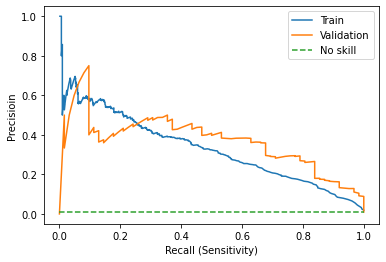

In [119]:
plt.plot(performance_dict_train['recall'],performance_dict_train['precision'])
plt.plot(performance_dict_val['recall'],performance_dict_val['precision'])

no_skill = len(y_true_val[y_true_val==1]) / len(y_true_val)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precisioin')
plt.legend(['Train','Validation','No skill'])
plt.show()

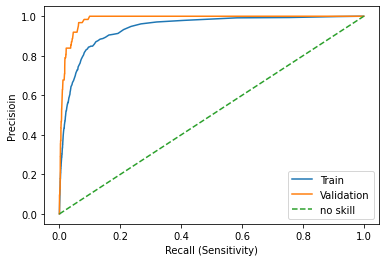

In [120]:
plt.plot(performance_dict_train['false positive rate'],performance_dict_train['true positive rate'])
plt.plot(performance_dict_val['false positive rate'],performance_dict_val['true positive rate'])
plt.plot([0,1],[0,1], linestyle='--', label='No Skill')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precisioin')
plt.legend(['Train','Validation','no skill'])


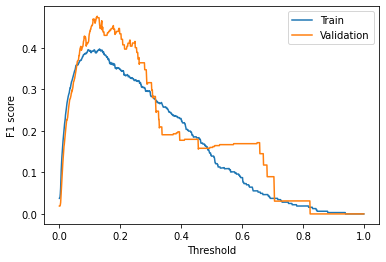

In [121]:
plt.plot(prediction_thresholds,performance_dict_train['f1'])
plt.plot(prediction_thresholds,performance_dict_val['f1'])
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.legend(['Train','Validation','no skill'])